## Brain decoding prediction analysis

This notebook compares quantitative properties of the brain decoder predictions for different trained decoders / subjects / target representations.

In [113]:
from collections import defaultdict
import itertools
from pathlib import Path
import re
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io
from scipy import stats as st
from tqdm import tqdm_notebook
sns.set(style="whitegrid", context="paper", font_scale=3.5, rc={"lines.linewidth": 2.5})

%load_ext autoreload
%autoreload 2

sys.path.append("../src")
from rsa import rsa_encodings
import util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
decoder_path = Path("../models/decoders")
bert_encoding_path = Path("../models/bert")
sentences_path = Path("../data/sentences/stimuli_384sentences.txt")
brains_path = Path("../data/brains")

bert_base_model = "uncased_L-12_H-768_A-12"
finetune_desc = "finetune-250"

In [47]:
bert_models = ["SST", "SQuAD", "LM_pos", "MNLI", "QQP", "LM", "LM_contentonly", "LM_lmonly", "LM_randommask", "LM_scrambled", "LM_scrambled_para", "LM_contentonly_scrambled", "LM_lmonly_scrambled"]
# Models which should appear in the final report figures
report_models = ["SQuAD", "QQP", "MNLI", "SST", "LM", "LM_scrambled", "LM_scrambled_para", "LM_pos", "glove"]
subjects = ["M02", "M04", "M07", "M08", "M09", "M14", "M15", "P01"]
target_runs = [1, 2, 3, 4, 5, 6, 7, 8, 9]
steps = list(range(5, 255, 5))

In [4]:
figure_path = Path("../reports/figures")
figure_path.mkdir(exist_ok=True)

### Data loading

In [5]:
PCA_DIM = 256

In [53]:
# Load model encoding data.
encodings = {}
steps_of_interest = [steps[-1]]
for model, run, step in tqdm_notebook(list(itertools.product(bert_models, target_runs, steps_of_interest)), desc="Loading model steps"):
    encoding_name = "encodings.%s.%s.%s-run%i-%i.npy" % (finetune_desc, bert_base_model, model, run, step)
    encoding_path = bert_encoding_path / encoding_name

    try:
        encodings[model, run, step] = util.load_encodings([encoding_path], project=PCA_DIM)
    except FileNotFoundError:
        print(model, run, step)
        continue

 62%|██████▏   | 2957/4753 [01:19<00:38, 46.54it/s]

SST 9 250
SQuAD 9 250
LM_pos 5 250
LM_pos 6 250
LM_pos 7 250
LM_pos 8 250
LM_pos 9 250
MNLI 9 250
QQP 9 250
LM 9 250
LM_contentonly 9 250
LM_lmonly 9 250
LM_randommask 5 250
LM_randommask 6 250
LM_randommask 7 250
LM_randommask 8 250
LM_randommask 9 250
LM_scrambled 9 250
LM_contentonly_scrambled 9 250
LM_lmonly_scrambled 9 250



In [54]:
# Add GloVe model
encodings["GloVe", 1, 250] = util.load_encodings([bert_encoding_path / "encodings.glove.npy"], project=PCA_DIM)

In [55]:
encs2 = {"/".join(str(x) for x in k): v for k, v in encodings.items()}

In [56]:
np.savez("../models/bert_encodings_20190518-1242.npz", **encs2)

In [67]:
# Load decoder prediction data.
predictions = {}
for subject in tqdm_notebook(subjects, desc="Subjects"):
    for model, run, step in tqdm_notebook(list(itertools.product(bert_models, target_runs, steps_of_interest)), desc="Loading predictions for target models", leave=False):
        decoded_path = decoder_path / ("encodings.%s.%s.%s-run%i-%i-%s.pred.npy" % (finetune_desc, bert_base_model, model, run, step, subject))
        try:
            predictions[model, run, step, subject] = np.load(decoded_path)
        except FileNotFoundError: pass
        
    # Add baseline predictions.
    baseline_path = decoder_path / ("encodings.%s-%s.pred.npy" % (bert_base_model, subject))
    predictions["_", None, None, subject] = np.load(baseline_path)
    
    # Add GloVe predictions
    predictions["GloVe", 1, 250, subject] = np.load(decoder_path / ("encodings.glove-%s.pred.npy" % subject))

In [68]:
preds2 = {"/".join(str(x) for x in k): v for k, v in predictions.items()}

In [69]:
np.savez("../models/decoder_predictions_20190518-1242.npz", **preds2)

#### Reload from cache ..

If restarting this notebook, we can hopefully load the cached files instead:

In [70]:
predictions = np.load("../models/decoder_predictions_20190518-1242.npz")
predictions = {tuple(k.split("/")): v for k, v in predictions.items()}
encodings = np.load("../models/bert_encodings_20190518-1242.npz")
encodings = {tuple(k.split("/")): v for k, v in encodings.items()}

In [71]:
# Normalize encodings as in regression.
encodings = {k: v - v.mean(axis=0) for k, v in encodings.items()}
encodings = {k: v / np.linalg.norm(v, axis=1, keepdims=True) for k, v in encodings.items()}

### Prepare sentence data

In [72]:
sentences = util.load_sentences(sentences_path)

### Load original encodings

In [73]:
# Load pretrained model encodings.
encoding_path = bert_encoding_path / ("encodings.%s.npy" % (bert_base_model))
baseline_encoding = util.load_encodings([encoding_path], project=PCA_DIM)

### Error analysis

Averaging across subjects, how does per-sentence error change over time?

In [74]:
pred_mses = {}

In [75]:
for (model, run, step), encodings_i in encodings.items():
    mses = {}
    for subject in subjects:
        try:
            mses_s = np.linalg.norm(encodings_i - predictions[model, run, step, subject], axis=1)
        except:
            continue
        
        mses[subject] = pd.Series(mses_s, name="mse")
        
    if mses:
        pred_mses[model, int(run), int(step)] = pd.concat(mses, names=["subject"])

In [76]:
# Add original encoding MSEs.
original_mses = {}
for subject in subjects:
    original_mses[subject] = pd.Series(np.linalg.norm(baseline_encoding - predictions["_", "None", "None", subject], axis=1),
                                       name="mse")
    pred_mses["_", 0, 250] = pd.concat(mses, names=["subject"])

In [77]:
pred_mses = pd.DataFrame(pd.concat(pred_mses, names=["model", "run", "step"])).sort_index()
pred_mses.index.names = ["model", "run", "step", "subject", "sentence"]

In [78]:
pred_mses.head()

mse
model run step subject sentence          
GloVe 1   250  M02     0         1.129727
                       1         1.358157
                       2         1.165938
                       3         1.086545
                       4         0.988025

In [79]:
first_mses = pred_mses.loc[pd.IndexSlice["_", 0, 250, :, :], :]
last_mses = pred_mses.loc[pd.IndexSlice[:, :, 250, :, :], :]

In [80]:
first_mses.index = first_mses.index.droplevel((0, 1, 2))

In [81]:
mse_diffs = last_mses.groupby(["model", "run", "step"]) \
    .apply(lambda xs: xs.reset_index(level=(0,1,2), drop=True) - first_mses)

In [82]:
mse_diffs.head()

mse
model run step subject sentence     
GloVe 1   250  M02     0         0.0
                       1         0.0
                       2         0.0
                       3         0.0
                       4         0.0

In [83]:
mse_diffs["abs_mse"] = mse_diffs.mse.transform(np.abs)

In [84]:
mse_diffs.sort_values("abs_mse", ascending=False)

mse   abs_mse
model  run step subject sentence                    
SST    4   250  M15     144       0.737135  0.737135
       1   250  M15     144       0.733042  0.733042
       5   250  M15     144       0.710902  0.710902
       4   250  M09     247       0.709474  0.709474
       3   250  M15     144       0.706788  0.706788
       6   250  M15     144       0.705636  0.705636
       2   250  M07     59        0.694113  0.694113
       5   250  P01     156       0.685160  0.685160
       4   250  M02     9         0.684062  0.684062
       2   250  P01     187       0.682386  0.682386
       3   250  M08     59       -0.678796  0.678796
QQP    3   250  M09     380       0.672848  0.672848
                M08     40        0.660897  0.660897
SST    4   250  M04     295      -0.658715  0.658715
                P01     77        0.657805  0.657805
       5   250  P01     202       0.656509  0.656509
                M14     27        0.656396  0.656396
       4   250  P01     187       0.656234  0.656234
       6   250  P01     156       0.650500  0.650500
                M09     243      -0.641759  0.641759
       7   250  M09     243      -0.640817  0.640817
       4   250  M07     247       0.637756  0.637756
       5   250  M04     59       -0.636137  0.636137
       2   250  M02     48        0.634669  0.634669
       5   250  M14     265       0.633980  0.633980
       6   250  P01     187       0.628606  0.628606
LM_pos 1   250  M15     340       0.623758  0.623758
SST    6   250  M04     59       -0.622071  0.622071
SQuAD  4   250  M04     115       0.617976  0.617976
SST    5   250  M09     243      -0.616946  0.616946
...                                    ...       ...
GloVe  1   250  M14     103       0.000000  0.000000
                        102       0.000000  0.000000
                        101       0.000000  0.000000
                        100       0.000000  0.000000
                        99        0.000000  0.000000
                        119       0.000000  0.000000
                        121       0.000000  0.000000
                        143       0.000000  0.000000
                        133       0.000000  0.000000
                        142       0.000000  0.000000
                        141       0.000000  0.000000
                        140       0.000000  0.000000
                        139       0.000000  0.000000
                        138       0.000000  0.000000
                        137       0.000000  0.000000
                        136       0.000000  0.000000
                        135       0.000000  0.000000
                        134       0.000000  0.000000
                        132       0.000000  0.000000
                        122       0.000000  0.000000
                        131       0.000000  0.000000
                        130       0.000000  0.000000
                        129       0.000000  0.000000
                        128       0.000000  0.000000
                        127       0.000000  0.000000
                        126       0.000000  0.000000
                        125       0.000000  0.000000
                        124       0.000000  0.000000
                        123       0.000000  0.000000
_      0   250  P01     383       0.000000  0.000000

[291840 rows x 2 columns]

### RSA in MSE diffs between models

In [85]:
avg_mse_diffs = mse_diffs.groupby(["model", "run"]).apply(lambda xs: xs.groupby("sentence").abs_mse.mean())
avg_mse_diffs.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4315: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))


sentence        0         1         2         3         4         5    \
model run                                                               
GloVe 1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
LM    5    0.100241  0.065549  0.059357  0.082176  0.067046  0.055689   
      6    0.074580  0.073241  0.054436  0.088326  0.078455  0.046825   
      7    0.116807  0.109342  0.060010  0.079507  0.118010  0.055224   
      8    0.088427  0.096888  0.052844  0.076811  0.076708  0.060839   

sentence        6         7         8         9      ...          374  \
model run                                            ...                
GloVe 1    0.000000  0.000000  0.000000  0.000000    ...     0.000000   
LM    5    0.057113  0.052036  0.071427  0.193034    ...     0.069614   
      6    0.083507  0.041936  0.087170  0.138536    ...     0.057296   
      7    0.078101  0.047755  0.058123  0.170781    ...     0.071480   
      8    0.082413  0.064174  0.067699  0.157607    ...     0.059814   

sentence        375       376       377       378       379       380  \
model run                                                               
GloVe 1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
LM    5    0.089508  0.060491  0.055374  0.089003  0.058450  0.102517   
      6    0.089022  0.061511  0.025177  0.077274  0.069825  0.098503   
      7    0.077250  0.052412  0.046025  0.082282  0.062921  0.116773   
      8    0.065606  0.094241  0.055054  0.106868  0.059531  0.104934   

sentence        381       382       383  
model run                                
GloVe 1    0.000000  0.000000  0.000000  
LM    5    0.087787  0.131786  0.079789  
      6    0.113128  0.132934  0.084753  
      7    0.097520  0.154583  0.101564  
      8    0.113377  0.129246  0.082943  

[5 rows x 384 columns]

In [86]:
mse_corrs = []
for ((model1, run1), row1), ((model2, run2), row2) in itertools.combinations(avg_mse_diffs.iterrows(), 2):
    mse_corrs.append((model1, run1, model2, run2, st.pearsonr(row1, row2)[0]))
    
mse_corrs = pd.DataFrame(mse_corrs, columns=["model1", "run1", "model2", "run2", "pearsonr"])
mse_corrs = mse_corrs.groupby(["model1", "model2"]).pearsonr.mean()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [87]:
heatmap = np.zeros((len(bert_models), len(bert_models)))
for i, model1 in enumerate(bert_models):
    for j, model2 in enumerate(bert_models):
            
        try:
            heatmap[i, j] = mse_corrs[model1, model2]
        except:
            heatmap[i, j] = mse_corrs.get((model2, model1), 1.0)

Text(0.5,1,'Correlation in sentence MSE diffs')

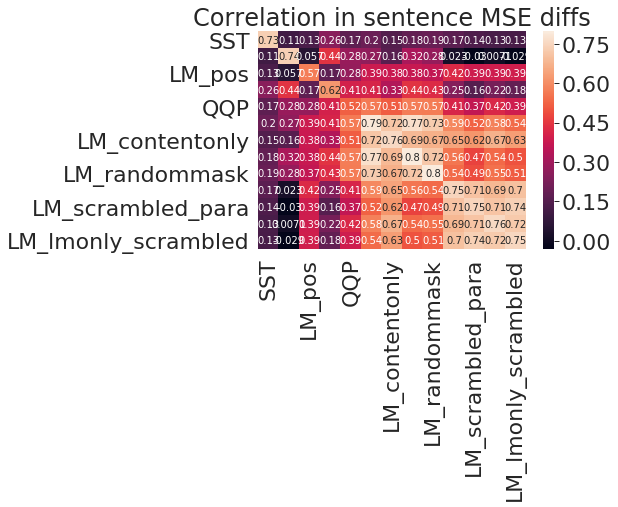

In [88]:
heatmap = pd.DataFrame(heatmap, index=bert_models, columns=bert_models)
sns.heatmap(data=heatmap, annot=True)
plt.title("Correlation in sentence MSE diffs")

### RSA in MSE diffs between model runs: LM_scrambled

In [89]:
avg_mse_diffs = mse_diffs.loc["LM_scrambled"].groupby("run").apply(lambda xs: xs.groupby("sentence").abs_mse.mean())
avg_mse_diffs.head()

sentence,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
run,,,,,,,,,,,,,,,,,,,,,
1,0.085688,0.104440,0.054545,0.087417,0.075501,0.084850,0.075453,0.064442,0.082300,0.084861,...,0.077640,0.092415,0.050150,0.039049,0.087177,0.058833,0.111623,0.131193,0.145773,0.103502
2,0.066613,0.089646,0.048245,0.120863,0.096845,0.048245,0.076290,0.062463,0.071673,0.070003,...,0.066177,0.065749,0.070164,0.037168,0.037255,0.057485,0.111519,0.120068,0.139212,0.085998
3,0.068885,0.095213,0.079026,0.091246,0.083117,0.039662,0.093957,0.071452,0.067136,0.060181,...,0.071479,0.065890,0.048206,0.051845,0.068728,0.044018,0.090080,0.120216,0.147906,0.092958
4,0.062349,0.111310,0.074989,0.090099,0.097956,0.055243,0.084605,0.068632,0.045643,0.113168,...,0.073382,0.092819,0.076573,0.043526,0.073277,0.041100,0.082476,0.122478,0.138483,0.104866
5,0.062691,0.093882,0.081383,0.080861,0.094274,0.090118,0.075499,0.064202,0.059794,0.057072,...,0.086790,0.084584,0.049597,0.035741,0.077395,0.045065,0.086080,0.119384,0.114689,0.092339


In [90]:
mse_corrs = {}
for pair in itertools.combinations(avg_mse_diffs.index, 2):
    mse_corrs[pair], _ = st.pearsonr(avg_mse_diffs.loc[pair[0]], avg_mse_diffs.loc[pair[1]])

In [91]:
idx = list(avg_mse_diffs.index)
heatmap = np.zeros((len(idx), len(idx)))
for i, model1 in enumerate(idx):
    for j, model2 in enumerate(idx):
            
        try:
            heatmap[i, j] = mse_corrs[model1, model2]
        except:
            heatmap[i, j] = mse_corrs.get((model2, model1), 1.0)

Text(0.5,1,'Correlation in sentence MSE diffs')

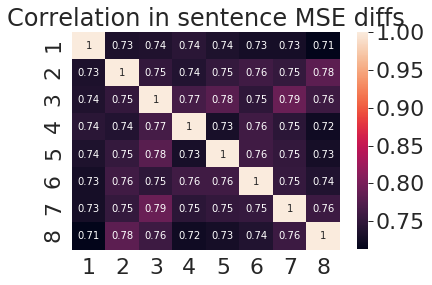

In [92]:
heatmap = pd.DataFrame(heatmap, index=idx, columns=idx)
sns.heatmap(data=heatmap, annot=True)
plt.title("Correlation in sentence MSE diffs")

Text(0.5,1,'LM_scrambled MSE diffs between runs')

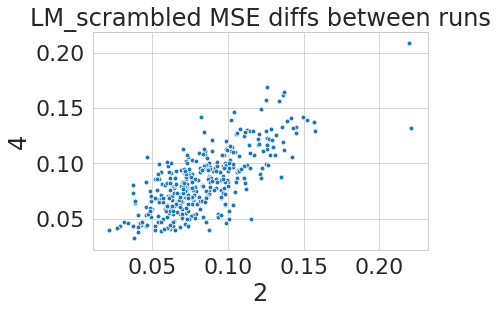

In [93]:
sns.scatterplot(x=2, y=4, data=avg_mse_diffs.T.reset_index())
plt.title("LM_scrambled MSE diffs between runs")

### RSA in MSE diffs between model runs: MNLI

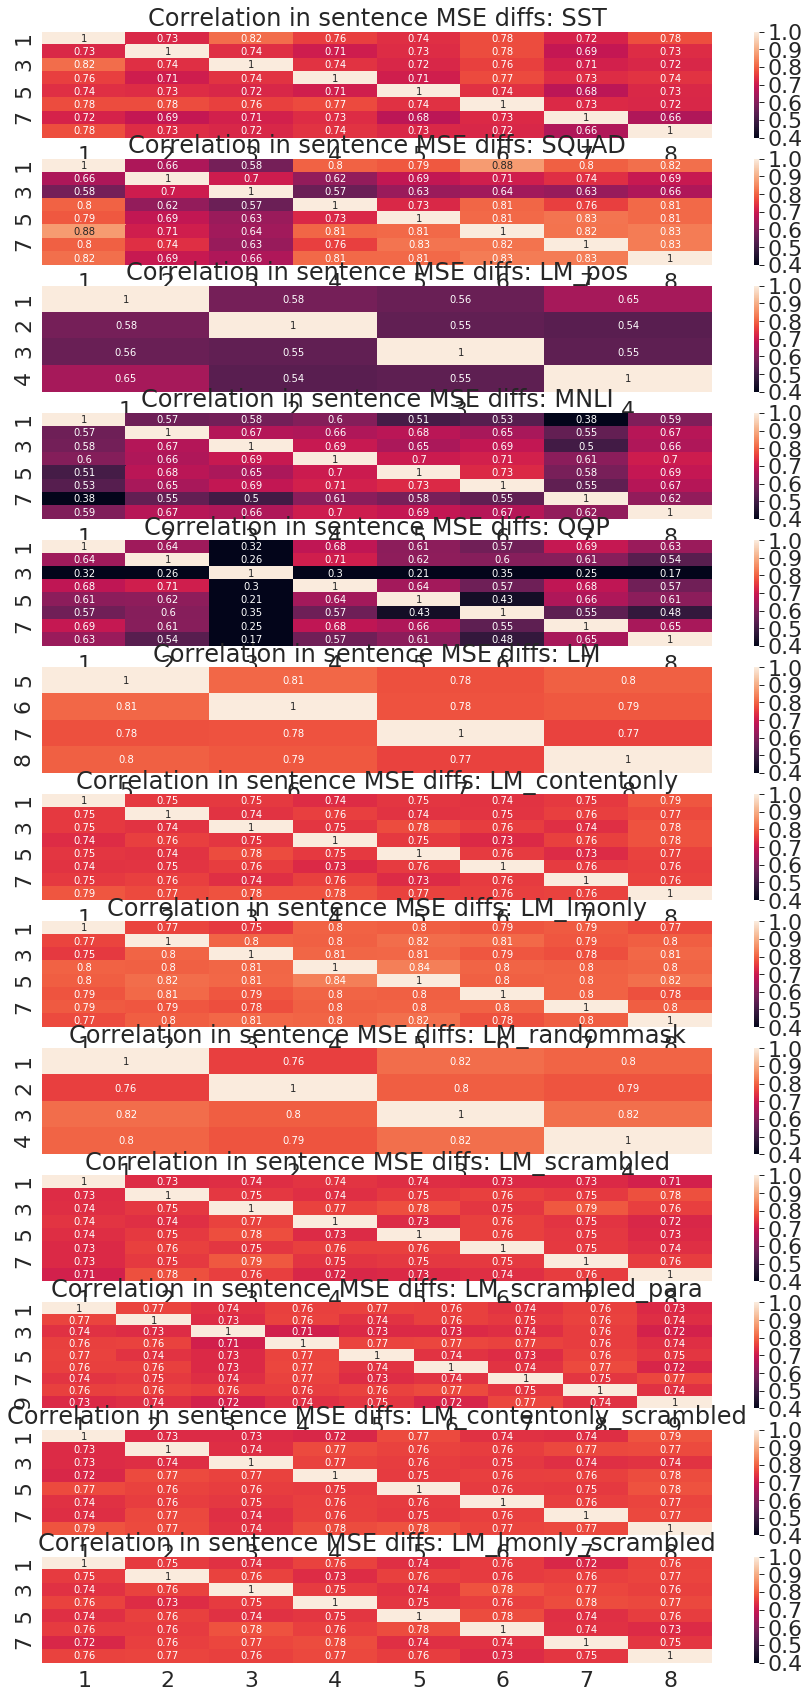

In [94]:
f, axs = plt.subplots(len(bert_models), figsize=(15, 30))
heatmaps = {}
for model, ax in tqdm_notebook(list(zip(bert_models, axs))):
    avg_mse_diffs = mse_diffs.loc[model].groupby("run").apply(lambda xs: xs.groupby("sentence").abs_mse.mean())
    mse_corrs = {}
    for pair in itertools.combinations(avg_mse_diffs.index, 2):
        mse_corrs[pair], _ = st.pearsonr(avg_mse_diffs.loc[pair[0]], avg_mse_diffs.loc[pair[1]])
        
    idx = list(avg_mse_diffs.index)
    heatmap = np.zeros((len(idx), len(idx)))
    for i, model1 in enumerate(idx):
        for j, model2 in enumerate(idx):

            try:
                heatmap[i, j] = mse_corrs[model1, model2]
            except:
                heatmap[i, j] = mse_corrs.get((model2, model1), 1.0)
                
    heatmaps[model] = pd.DataFrame(heatmap, index=idx, columns=idx)
    sns.heatmap(data=heatmaps[model], annot=True, ax=ax, vmin=0.4, vmax=1.0)
    ax.set_title("Correlation in sentence MSE diffs: %s" % model)

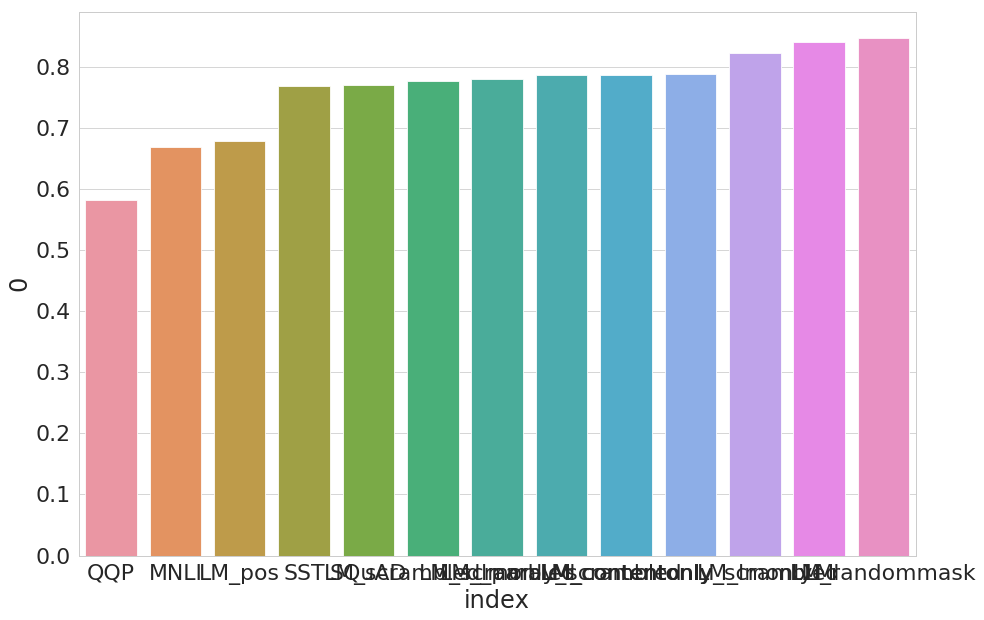

In [95]:
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x="index", y=0, data=pd.DataFrame.from_dict({k: v.mean().mean() for k, v in heatmaps.items()}, orient="index").sort_values(0).reset_index())

### RSA content analysis

In [96]:
rsa_inputs = {(model, run, step): enc for (model, run, step), enc in encodings.items()
              if int(step) == steps[-1]}
rsa_sims = rsa_encodings(rsa_inputs, collapse_fn=lambda key: key[0])


100%|██████████| 4753/4753 [01:50<00:00, 43.15it/s]

In [97]:
rsa_sims_avg = rsa_sims.groupby(["model1", "model2"]).pearsonr.mean()
rsa_sims_avg

model1                    model2                  
LM                        GloVe                       0.664218
                          LM                          0.981312
                          LM_contentonly              0.950047
                          LM_contentonly_scrambled    0.915644
                          LM_lmonly                   0.963069
                          LM_lmonly_scrambled         0.901253
                          LM_randommask               0.943504
                          LM_scrambled                0.908498
                          LM_scrambled_para           0.898941
LM_contentonly            GloVe                       0.667844
                          LM_contentonly              0.982325
                          LM_contentonly_scrambled    0.945836
                          LM_lmonly                   0.947186
                          LM_lmonly_scrambled         0.927459
                          LM_randommask               0.931055
    

In [98]:
# Present sorted by avg correlation with LM_scrambled
rsa_sims_dict = rsa_sims_avg.to_dict()
rsa_sims_dict.update({(k2, k1): v for (k1, k2), v in rsa_sims_dict.items()})
model_order = sorted(bert_models, key=lambda m: rsa_sims_dict[m, "LM_scrambled_para"])
heatmap = np.zeros((len(model_order), len(model_order)))
for i, model1 in enumerate(model_order):
    for j, model2 in enumerate(model_order):
        try:
            heatmap[i, j] = rsa_sims_avg[model1, model2]
        except:
            heatmap[i, j] = rsa_sims_avg.get((model2, model1), 1.0)

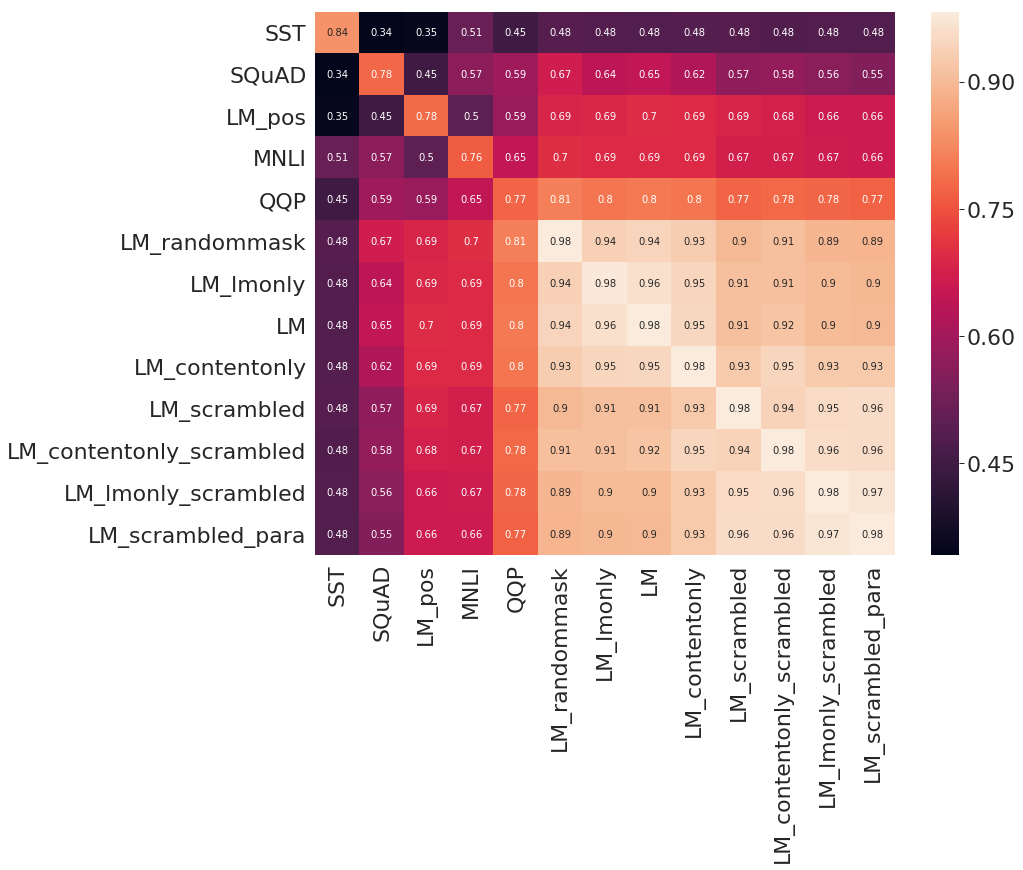

In [99]:
f, ax = plt.subplots(figsize=(13,10))
heatmap_df = pd.DataFrame(heatmap, index=model_order, columns=model_order)
sns.heatmap(data=heatmap_df, annot=True)

In [114]:
%matplotlib agg

# replot the above, but for report
rsa_sims_dict = rsa_sims_avg.to_dict()
rsa_sims_dict.update({(k2, k1): v for (k1, k2), v in rsa_sims_dict.items()})
model_order = sorted(report_models, key=lambda m: rsa_sims_dict[m, "LM_scrambled_para"])
heatmap = np.zeros((len(model_order), len(model_order)))
for i, model1 in enumerate(model_order):
    for j, model2 in enumerate(model_order):
        try:
            heatmap[i, j] = rsa_sims_avg[model1, model2]
        except:
            heatmap[i, j] = rsa_sims_avg.get((model2, model1), 1.0)
            
f, ax = plt.subplots(figsize=(14,11))
heatmap_df = pd.DataFrame(heatmap, index=model_order, columns=model_order)
sns.heatmap(data=heatmap_df, annot=True, annot_kws={"size": 24})
plt.xticks(rotation=30, ha="right")

plt.tight_layout()
plt.savefig(figure_path / "rsa.pdf")
plt.close(f)

%matplotlib inline